In [14]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_C import CAdaptive_C_RK4
from adaptive_C_sqrt import CAdaptive_C_RK4_sqrt
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

In [15]:
def get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    #coeff = 2 * num_electrons / S.trace() * S
    return S @ linalg.funm(inv_S @ H, 
                    lambda _: 1 / (1 + np.exp(beta * (_ - mu))))

In [16]:
def alt_get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    #coeff = 2 * num_electrons / S.trace() * S
    return inv_S @ linalg.funm(S @ H, 
                    lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

In [17]:
def funm_herm(a, func):
    w, v = linalg.eigh(a)
    w = func(w)
    return (v * w).dot(v.conj().T)

In [18]:
def get_mu(H, S, nel, beta):
    # Emulate william's approach
    # Orthogonalize H
    isq = funm_herm(S, lambda x: -1/np.sqrt(x))
    Ho = isq @ H @ isq
    
    # Use eigenvalues of Ho to get first guess for chemical potential
    w, v = linalg.eigh(Ho)
    mu = w[int(nel/2)-1] + 0.5*(w[int(nel/2)] - w[int(nel/2)-1])
    
    # Construct P from first guess
    we = [1.0/(1 + np.exp(beta*(x - mu))) for x in w]
    P = v.dot(np.diag(we)).dot(v.T)
    
    # Use binary search to iterate towards the mu that gets the trace correct
    mu2 = mu
    left = w[0]
    right = w[-1]
    print("Chemical Potential, Number of Electrons")
    while abs(np.trace(P) - int(nel/2)) > 1e-6:
        mu2 = left  + 0.5*(right - left)
        we = [1.0/(1 + np.exp(beta*(x - mu2))) for x in w]
        P = v.dot(np.diag(we)).dot(v.T)
        print(mu2, 2*np.trace(P))
        if np.trace(P) > int(nel/2):
            right = mu2
        else:
            left = mu2
    occ, _ = linalg.eigh(P)
    
    return occ, mu2

In [19]:
def energy_error(c, mu):
    wom_E = np.trace(c.A @ c.inv_ovlp @ c.rho)
    isq = funm_herm(c.ovlp, lambda x: -1/np.sqrt(x))
    Ho = isq @ c.H @ isq
    w, v = linalg.eigh(Ho)
    
    we = [1.0/(1 + np.exp(beta*(x - mu))) for x in w]
    P = v.dot(np.diag(we)).dot(v.T)
    E = np.trace(P @ Ho)
    
    #fd_E = np.trace(c.A @ c.inv_ovlp @ fd)
    print("Band structure energy: ", wom_E, " hartree")
    print("Rel Error: ", np.abs(wom_E - E) / np.abs(E))
    print("Percentage: {:%}".format(np.abs(wom_E - E) / np.abs(E)))

In [20]:
def plot_results_fd_vs_c(num_electrons, fd, c):
    H = c.H
    S = c.ovlp
    
    # Plot final eigenvalue spectra of the exact solution and our methods results
    fignum = 1
    plt.figure(fignum)
    #plt.title("Populations - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(fd, S)[::-1], 'ks-', label="Exact by FD")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(c.rho, S)[::-1], 'r^-', 
             label="Can. WOM")
    plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/rk2_C_pop.png", format='png', dpi=300)
    print(c.beta)
    
    # Plot increments of dbeta that our method took
    fignum += 1
    plt.figure(fignum)
    plt.title("Variable step method in action - " +str(num_electrons) + " electrons")
    plt.plot(c.beta_increments, '*-')
    plt.xlabel('steps')
    plt.ylabel('dbeta')
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_dbeta_inc.png", format='png', dpi=300)
    
    # Plot number of electrons
    fignum += 1
    plt.figure(fignum)
    plt.title("Change in number of electrons - " + str(num_electrons) + " electrons")
    plt.plot(np.array(c.num_electron_list), '*-')
    plt.xlabel("steps")
    plt.ylabel("num_electrons")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_num_electrons.png", format='png', dpi=300)
    
    # Plot chemical potential
    fignum += 1
    plt.figure(fignum)
    plt.title("Change in chemical potential - " + str(num_electrons) + " electrons")
    plt.plot(c.mu_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("mu")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_chem_pot.png", format='png', dpi=300)

    # Check beta vs step size
    fignum += 1
    plt.figure(fignum)
    beta_vals = np.cumsum(c.beta_increments)
    plt.plot(c.beta_increments, beta_vals)
    plt.xlabel("dbeta")
    plt.ylabel("beta")
    plt.title("beta vs step size - " + str(num_electrons) + " electrons")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_beta_vs_stepsize.png", format='png', dpi=300)
    
    # Plot energy values
    fignum += 1
    plt.figure(fignum)
    plt.title("Energy values vs temp - " + str(num_electrons) + " electrons")
    plt.semilogy(beta_vals, (c.energy_vals - min(c.energy_vals))[:-1])
    plt.xlabel("beta")
    plt.ylabel("E(beta) - E.min")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_energy_vs_beta.png", format='png', dpi=300)
    
    # Plot energy values
    fignum += 1
    plt.figure(fignum)
    plt.title("Energy values vs steps - " + str(num_electrons) + " electrons")
    plt.semilogy((c.energy_vals - min(c.energy_vals))[:-1])
    plt.xlabel("steps")
    plt.ylabel("E(step) - E.min")
    plt.savefig("larger_matrices/sqrt_figs/C/" + str(num_electrons) + "/C_energy_vs_steps.png", format='png', dpi=300)

In [21]:
def best_linear_reg(T_data, cv_data, rem):
    # Get the point to start from that gives the best score for linear regression
    scores = []
    best_reg = None
    best_score = 1
    best_ind = 0
    for i in range(cv_data.size-rem):
        # Calculate linear regression
        reg = LinearRegression().fit(
            T_data[i:].reshape(-1, 1),
            cv_data[i:].real.reshape(-1, 1)    
        )
    
        # Calculate score
        score = 1-reg.score(
                        T_data[i:].reshape(-1, 1),
                        cv_data[i:].real.reshape(-1, 1)
                    )
    
        scores.append(score)
        if score < best_score:
            best_score = score
            best_reg = reg
            best_ind = i
            
    print("Best score and index: ", (1-best_score, best_ind))
    plt.figure(1)
    plt.plot(range(cv_data.size-rem), scores)
    plt.plot(best_ind, best_score, 'o', label='Best')
    plt.xlabel("Index")
    plt.ylabel('Score')
    plt.legend(numpoints=1)
    
    plt.figure(2)
    plt.plot(T_data[best_ind:], cv_data.real[best_ind:], 'ro', label='Data')
    plt.plot(T_data[best_ind:], best_reg.predict(T_data[best_ind:].reshape(-1, 1)),
            'k--', label='Predict')
    plt.xlabel("T (K)")
    plt.ylabel("$\\mathrm{C}_\\mathrm{v}$ (J/mol/K)")
    plt.savefig("larger_matrices/sqrt_figs/cv.png", format='png', dpi=300)
    #plt.legend(numpoints=1)
    print("Cv @ 298.15 K = ", best_reg.predict([[298.15]]))
    
    print("Slope = ", best_reg.coef_)


In [22]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [23]:
# Define path for matrices
matrices_path = "larger_matrices/"

### 16 atom supercell

[[-0.26428906  0.          0.         ... -0.01604723 -0.0417898
   0.        ]
 [ 0.         -0.07489732  0.         ... -0.02331523 -0.02600867
  -0.02309361]
 [ 0.          0.         -0.07643941 ...  0.01660782 -0.02110693
   0.        ]
 ...
 [-0.01604723 -0.02331523  0.01660782 ...  0.11989432  0.
   0.        ]
 [-0.0417898  -0.02600867 -0.02110693 ...  0.          0.12296059
   0.        ]
 [ 0.         -0.02309361  0.         ...  0.          0.
   0.11528535]]


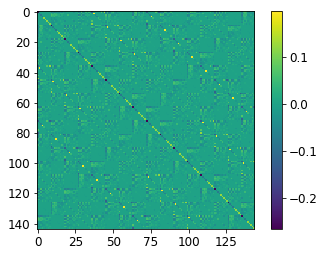

In [24]:
H_16 = mmread(matrices_path + "16_H.mtx")
type(H_16)
plt.imshow(H_16.toarray().real)
plt.colorbar()
print(H_16.toarray())

In [25]:
# Define path to H and S matrices
H_16 = mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()

E_16, V_16 = linalg.eigh(H_16, S_16)

# Define num_electrons and beta
num_electrons = 3*16
beta = 10
dbeta = 0.1

In [26]:
sqrt_c_16 = CAdaptive_C_RK4_sqrt(ovlp=S_16, H=H_16, num_electrons=num_electrons, dbeta=dbeta, 
                                 epsilon=1e-3, tol=0)
sqrt_c_16.propagate(beta, sqrt_c_16.single_step_rk2)
occ_16, mu_16 = get_mu(H_16, S_16, num_electrons, sqrt_c_16.beta)

Chemical Potential, Number of Electrons
0.1317521503746003 109.8891314723248
-0.1751413809335246 42.85645846307475
-0.02169461527946215 73.2804385249403
-0.09841799810649338 57.308689284637765
-0.136779689520009 49.885567442466694
-0.15596053522676678 46.31950842976643
-0.14637011237338787 48.09000217156578
-0.15116532380007733 47.20158226662427
-0.14876771808673261 47.64500407111686
-0.14756891523006024 47.86730670383851
-0.14696951380172407 47.9786054095407
-0.14666981308755597 48.034291542962826
-0.14681966344464004 48.00644541317635
-0.14689458862318205 47.992524645442145
-0.14685712603391105 47.9994848378486
-0.14683839473927554 48.00296507764963
-0.1468477603865933 48.001224945783115
-0.14685244321025218 48.00035488882432
-0.14685478462208162 47.99991986258858
-0.14685361391616691 48.00013737551948
-0.14685419926912427 48.00002861900728
-0.14685449194560296 47.999974240786244
-0.1468543456073636 48.000001429893835


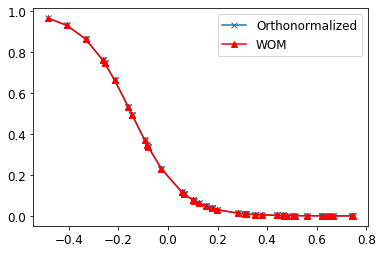

In [27]:
fig, axs = plt.subplots(1, 1)
axs.plot(E_16, occ_16[::-1], 'x-', label='Orthonormalized')
axs.plot(E_16, linalg.eigvalsh(sqrt_c_16.rho, S_16)[::-1], 'r^-', label='WOM')
plt.legend(numpoints=1)

In [28]:
ferm_exact_16 = get_exact(H_16, S_16, num_electrons, sqrt_c_16.beta, mu_16)
print(2*(sqrt_c_16.inv_ovlp @ ferm_exact_16).trace())

funm result may be inaccurate, approximate err = 1
48.00000142989392


In [29]:
energy_error(sqrt_c_16, mu_16)

Band structure energy:  (-4.844125180357899+0j)  hartree
Rel Error:  2.9242890097231636e-06
Percentage: 0.000292%


10.0


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


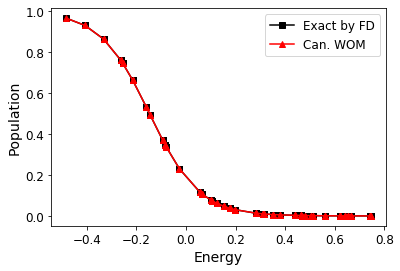

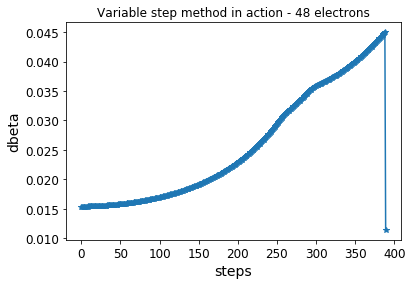

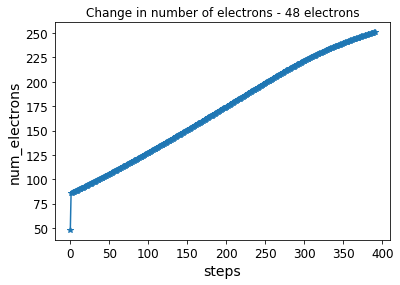

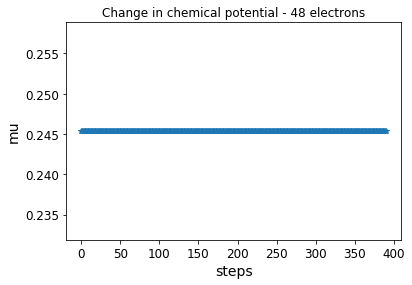

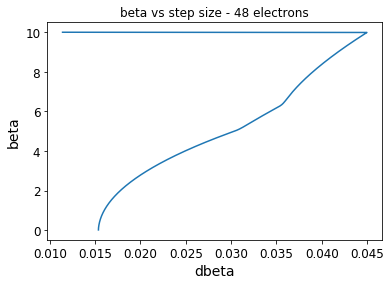

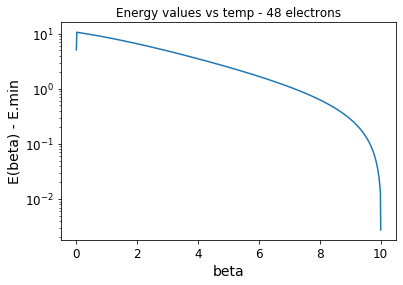

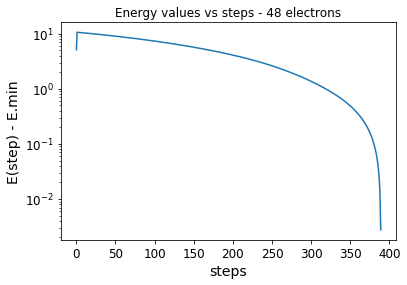

In [30]:
plot_results_fd_vs_c(num_electrons, ferm_exact_16, sqrt_c_16)

390
Best score and index:  (0.9738548411180483, 356)
Cv @ 298.15 K =  [[19.16579956]]
Slope =  [[0.00019762]]


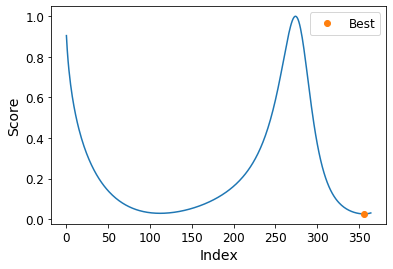

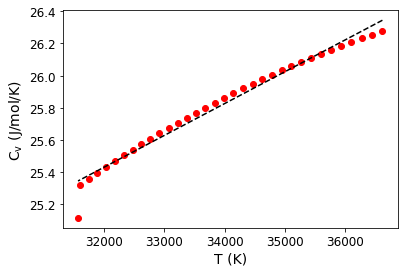

In [31]:
k = 3.168e-6 # Eh/K
beta_vals_16 = np.cumsum(sqrt_c_16.beta_increments)
T_16 = 1 / (beta_vals_16 * k) # K

# c.cv is in units of 1/atom multiplying by k gives Eh/atom/K
# To get J/mol/K we need to multiply by 4.3597447222×10^-18 J/Eh * Na atoms/mol
# This = 2.63e6
cv_16 = np.array(sqrt_c_16.cv) * k * 2.63e6 / 16
print(cv_16.size)
best_linear_reg(T_16, cv_16, 25)

In [32]:
coef = np.pi ** 2 / 3
N_el = 3
Tf = 13.5e4
Cv = coef * 3 * N_el / 2 * k * 1 / Tf * 2.63e6
print(Cv * 1e4)

9.136884970352485


### 54 atom supercell

In [22]:
# Define path to H and S matrices
H_54 = mmread(matrices_path + "54_H.mtx").toarray()
S_54 = mmread(matrices_path + "54_S.mtx").toarray()

E_54, V_54 = linalg.eigh(H_54, S_54)

beta = 100

# Define num_electrons and beta
num_electrons = 3*54

In [23]:
sqrt_c_54 = CAdaptive_C_RK4_sqrt(ovlp=S_54, H=H_54, num_electrons=num_electrons, dbeta=dbeta, 
                                 epsilon=1e-2, tol=0)
sqrt_c_54.propagate(beta, sqrt_c_54.single_step_rk2)
occ_54, mu_54 = get_mu(H_54, S_54, num_electrons, sqrt_c_54.beta)

Chemical Potential, Number of Electrons
0.13149685401313127 387.1353277229404
-0.17526902911425923 120.27311734334003
-0.021886087550563982 232.7190444184867
-0.09857755833241161 181.32679857919425
-0.13692329372333542 148.49232973157376
-0.11775042602787351 161.26109612020133
-0.10816399218014255 169.94726888047114
-0.11295720910400803 165.24105600213966
-0.11535381756594076 163.16919809611892
-0.11655212179690713 162.19628591343252
-0.11715127391239033 161.72419672720838
-0.11685169785464873 161.95908943608583
-0.11670190982577794 162.07739621872332
-0.11677680384021333 162.01817039641725
-0.11681425084743102 161.9886118628658
-0.11679552734382218 162.0033866094897
-0.1168048890956266 161.99599810698984
-0.1168002082197244 161.9996920758365
-0.11679786778177328 162.001539272049
-0.11679903800074884 162.00061565629088
-0.11679962311023662 162.00015386165092
-0.1167999156649805 161.99992296764052
-0.11679976938760855 162.00003841436995
-0.11679984252629452 161.9999806909363
-0.11679980

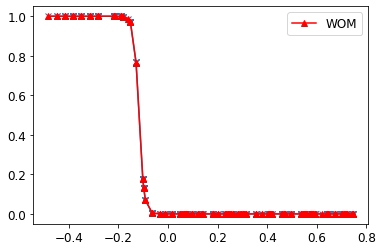

In [24]:
fig, axs = plt.subplots(1, 1)
axs.plot(E_54, occ_54[::-1], 'x-')
axs.plot(E_54, linalg.eigvalsh(sqrt_c_54.rho, S_54)[::-1], 'r^-', label='WOM')
plt.legend(numpoints=1)

In [25]:
ferm_exact_54 = get_exact(H_54, S_54, num_electrons, sqrt_c_54.beta, mu_54)
print(2 * np.trace(ferm_exact_54 @ sqrt_c_54.inv_ovlp))

funm result may be inaccurate, approximate err = 1
(161.99999872949496-6.071532165918825e-18j)


In [64]:
energy_error(sqrt_c_54, mu_54)

Band structure energy:  (-20.707903910323175+1.6851887013388314e-34j)  hartree
Rel Error:  0.00017631760374512057
Percentage: 0.017632%


100.0


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


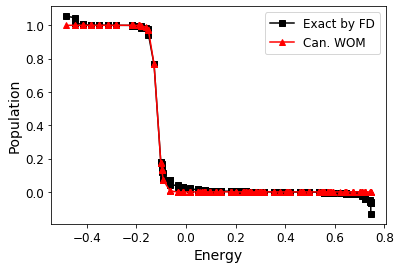

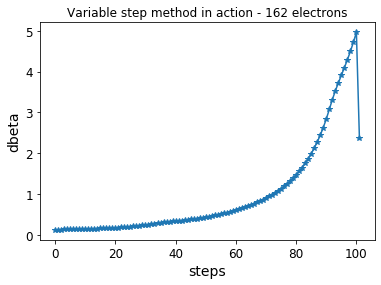

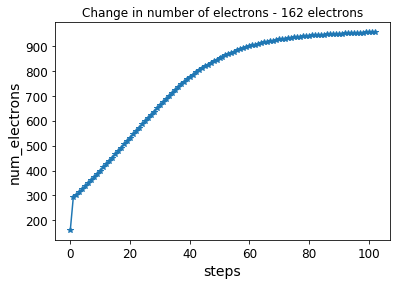

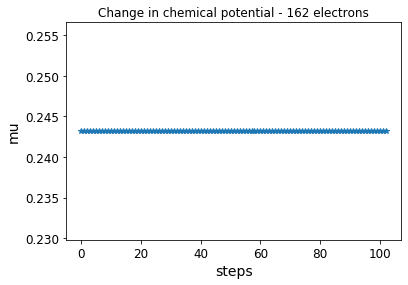

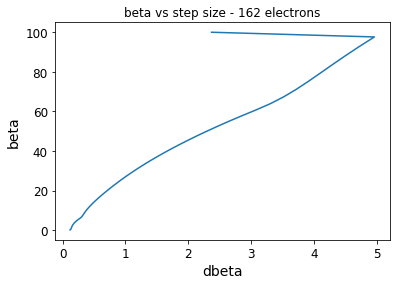

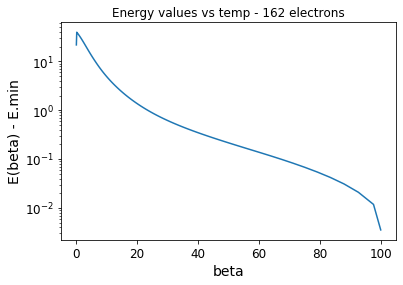

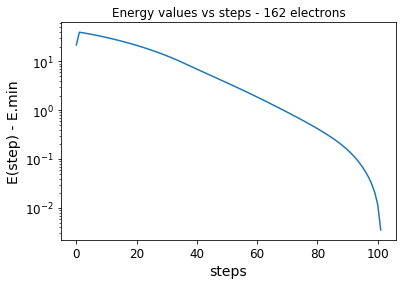

In [27]:
plot_results_fd_vs_c(num_electrons, ferm_exact_54, sqrt_c_54)

102
Best score and index:  (0.9978156963770433, 57)
Cv @ 298.15 K =  [[2.49658898]]
Slope =  [[0.00094447]]


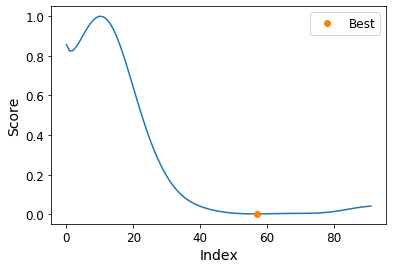

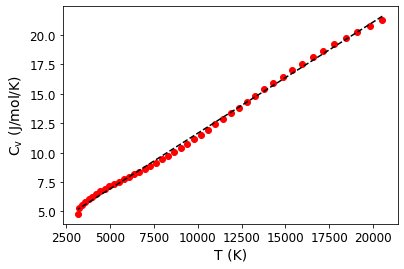

In [28]:
beta_vals_54 = np.cumsum(sqrt_c_54.beta_increments)
T_54 = 1 / (beta_vals_54 * k) # K

# c.cv is in uni0.912ts of 1/atom multiplying by k gives Eh/atom/K
# To get J/mol/K we need to multiply by 4.3597447222×10^-18 J/Eh * Na atoms/mol
# This = 2.63e6
cv_54 = np.array(sqrt_c_54.cv) * k * 2.63e6 / 54
print(cv_54.size)
best_linear_reg(T_54, cv_54, 10)

/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


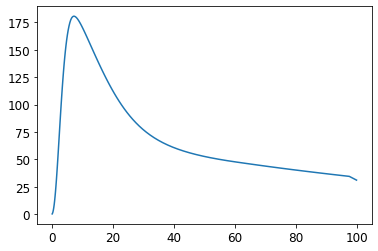

In [29]:
plt.plot(np.cumsum(sqrt_c_54.beta_increments), sqrt_c_54.cv)

### 128 atom supercell

In [30]:
# Define path to H and S matrices
H_128 = mmread(matrices_path + "128_H.mtx").toarray()
S_128 = mmread(matrices_path + "128_S.mtx").toarray()

E_128, V_128 = linalg.eigh(H_128, S_128)

# Define num_electrons and beta
num_electrons = 3*128

In [31]:
sqrt_c_128 = CAdaptive_C_RK4_sqrt(ovlp=S_128, H=H_128, num_electrons=num_electrons, 
                                  dbeta=dbeta, epsilon=1e-2, tol=1e-6)
sqrt_c_128.propagate(beta, sqrt_c_128.single_step_rk2)
occ_128, mu_128 = get_mu(H_128, S_128, num_electrons, sqrt_c_128.beta)

Chemical Potential, Number of Electrons
0.13175217685535012 897.363721691796
-0.1751413676931497 274.8549680971096
-0.021694595418899787 544.8276932412193
-0.09841798155602474 415.55338673485267
-0.13677967462458723 348.5294541441509
-0.11759882809030599 389.6679084783039
-0.1271892513574466 371.95951084763533
-0.1223940397238763 381.58276864539755
-0.11999643390709114 385.80420505139625
-0.12119523681548372 383.740679239315
-0.12059583536128743 384.78397668973594
-0.12089553608838557 384.2652475594475
-0.12104538645193465 384.00369753408177
-0.12112031163370918 383.87237243342884
-0.1210828490428219 383.93808093204484
-0.12106411774737827 383.9709007121469
-0.12105475209965647 383.98730199188253
-0.12105006927579556 383.99550048004863
-0.12104772786386511 383.9995991863161
-0.12104655715789989 384.00164840500975
-0.1210471425108825 384.00062380686586
-0.1210474351873738 384.0001114993917
-0.12104758152561945 383.99985534355415
-0.12104750835649664 383.99998342164804
-0.121047471771935

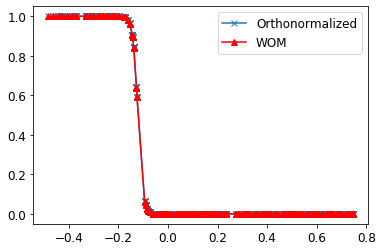

In [32]:
fig, axs = plt.subplots(1, 1)
axs.plot(E_128, occ_128[::-1], 'x-', label='Orthonormalized')
axs.plot(E_128, linalg.eigvalsh(sqrt_c_128.rho, S_128)[::-1], 'r^-', label='WOM')
plt.legend(numpoints=1)

In [33]:
ferm_exact_128 = get_exact(H_128, S_128, num_electrons, sqrt_c_128.beta, mu_128)
print(2 * np.trace(ferm_exact_128 @ sqrt_c_128.inv_ovlp))

funm result may be inaccurate, approximate err = 1
(383.9999994313864+5.312590645178972e-18j)


In [65]:
energy_error(sqrt_c_128, mu_128)

Band structure energy:  (-49.30895853387457+1.3481509610710651e-33j)  hartree
Rel Error:  0.0002017208789040384
Percentage: 0.020172%


100.0


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


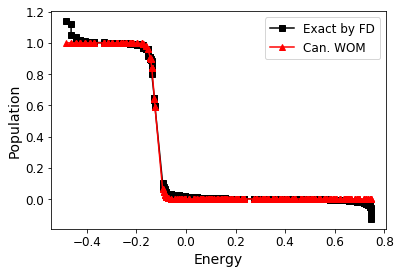

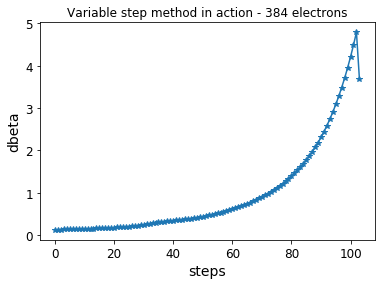

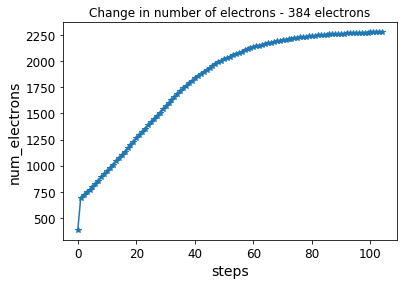

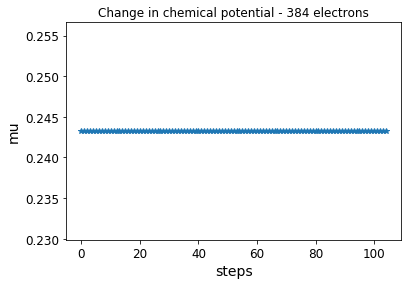

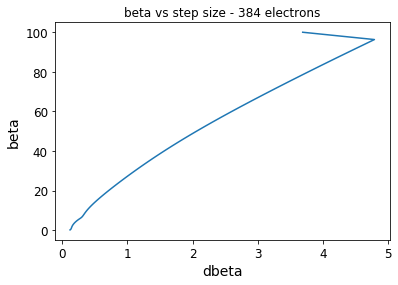

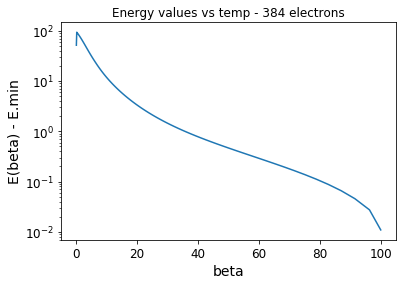

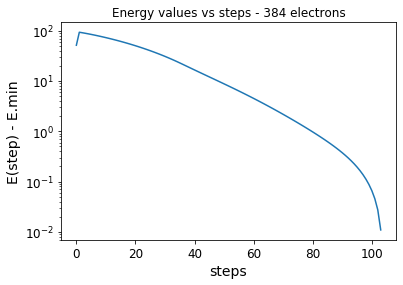

In [35]:
plot_results_fd_vs_c(num_electrons, ferm_exact_128, sqrt_c_128)

104
Best score and index:  (0.9989848933361709, 64)
Cv @ 298.15 K =  [[1.33830982]]
Slope =  [[0.00109803]]


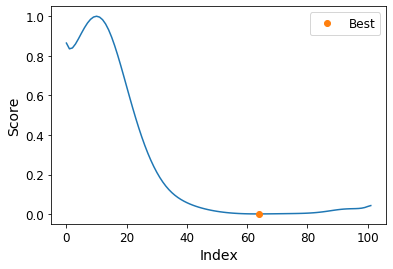

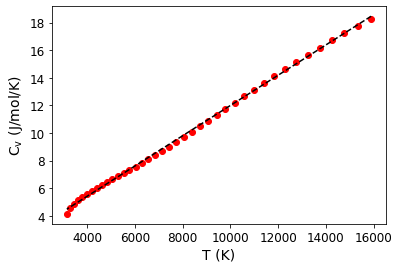

In [36]:
beta_vals_128 = np.cumsum(sqrt_c_128.beta_increments)
T_128 = 1 / (beta_vals_128 * k) # K

# c.cv is in units of 1/atom multiplying by k gives Eh/atom/K
# To get J/mol/K we need to multiply by 4.3597447222×10^-18 J/Eh * Na atoms/mol
# This = 2.63e6
cv_128 = np.array(sqrt_c_128.cv) * k * 2.63e6 / 128
print(cv_128.size)
best_linear_reg(T_128, cv_128, 2)

### 250 atom supercell

In [37]:
# Define path to H and S matrices
H_250 = mmread(matrices_path + "250_H.mtx").toarray()
S_250 = mmread(matrices_path + "250_S.mtx").toarray()

E_250, V_250 = linalg.eigh(H_250, S_250)

# Define num_electrons and beta
num_electrons = 3*250

E_250, V_250 = linalg.eigh(H_250, S_250)

In [38]:
sqrt_c_250 = CAdaptive_C_RK4_sqrt(ovlp=S_250, H=H_250, num_electrons=num_electrons,
                                  dbeta=dbeta, epsilon=1e-2, tol=1e-6)
sqrt_c_250.propagate(beta, sqrt_c_250.single_step_rk2)
occ_250, mu_250 = get_mu(H_250, S_250, num_electrons, sqrt_c_250.beta)

Chemical Potential, Number of Electrons
0.13165460358876324 1781.5427596484615
-0.17519015796442194 576.2067119555293
-0.02176777718782935 1086.7790378652699
-0.09847896757612565 795.4230724646451
-0.13683456277027378 676.0983755385629
-0.11765676517319971 726.8720192225323
-0.10806786637466267 759.6368538362366
-0.11286231577393119 742.5357472282922
-0.11046509107429693 750.9364314037105
-0.11166370342411405 746.6937058010233
-0.1110643972492055 748.8050201055589
-0.11076474416175122 749.8682882980036
-0.11061491761802408 750.4017601932678
-0.11068983088988765 750.1348731016271
-0.11072728752581944 750.0015427615256
-0.11074601584378532 749.9349060262452
-0.11073665168480237 749.96822202037
-0.1107319696053109 749.9848817978648
-0.11072962856556517 749.9932121314614
-0.11072845804569231 749.9973774094397
-0.11072787278575588 749.9994600762197
-0.11072758015578765 750.0005014165571
-0.11072772647077177 749.9999807458095
-0.11072765331327972 750.0002410810384
-0.11072768989202575 750.00

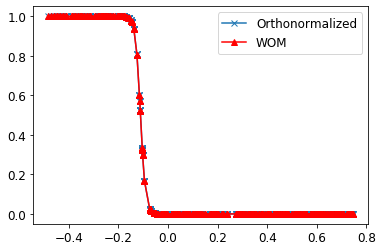

In [39]:
fig, axs = plt.subplots(1, 1)
axs.plot(E_250, occ_250[::-1], 'x-', label='Orthonormalized')
axs.plot(E_250, linalg.eigvalsh(sqrt_c_250.rho, S_250)[::-1], 'r^-', label='WOM')
plt.legend(numpoints=1)

In [40]:
ferm_exact_250 = get_exact(H_250, S_250, num_electrons, sqrt_c_250.beta, mu_250)

funm result may be inaccurate, approximate err = 1


In [45]:
print(2 * np.trace(ferm_exact_250 @ sqrt_c_250.inv_ovlp))
print(2 * np.trace(ferm_exact_250 @ sqrt_c_250.ovlp))

750.0000010844938
4456.063547803055


In [46]:
occ_250, mu_250 = get_mu(H_250, S_250, num_electrons, sqrt_c_250.beta)

Chemical Potential, Number of Electrons
0.13165460358876324 1781.5427596484615
-0.17519015796442194 576.2067119555293
-0.02176777718782935 1086.7790378652699
-0.09847896757612565 795.4230724646451
-0.13683456277027378 676.0983755385629
-0.11765676517319971 726.8720192225323
-0.10806786637466267 759.6368538362366
-0.11286231577393119 742.5357472282922
-0.11046509107429693 750.9364314037105
-0.11166370342411405 746.6937058010233
-0.1110643972492055 748.8050201055589
-0.11076474416175122 749.8682882980036
-0.11061491761802408 750.4017601932678
-0.11068983088988765 750.1348731016271
-0.11072728752581944 750.0015427615256
-0.11074601584378532 749.9349060262452
-0.11073665168480237 749.96822202037
-0.1107319696053109 749.9848817978648
-0.11072962856556517 749.9932121314614
-0.11072845804569231 749.9973774094397
-0.11072787278575588 749.9994600762197
-0.11072758015578765 750.0005014165571
-0.11072772647077177 749.9999807458095
-0.11072765331327972 750.0002410810384
-0.11072768989202575 750.00

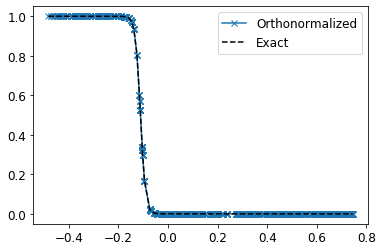

In [47]:
fig, axs = plt.subplots(1, 1)
axs.plot(E_250, occ_250[::-1], 'x-', label='Orthonormalized')
axs.plot(E_250, linalg.eigvalsh(ferm_exact_250, S_250)[::-1], 'k--', label='Exact')
plt.legend(numpoints=1)

In [66]:
energy_error(sqrt_c_250, mu_250)

Band structure energy:  (-96.60298901065782+0j)  hartree
Rel Error:  0.00017245152780399632
Percentage: 0.017245%


100.0


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


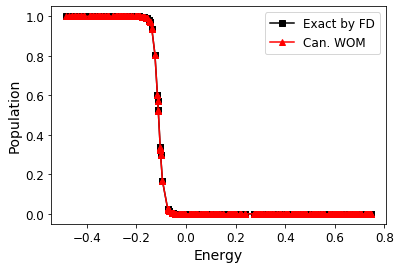

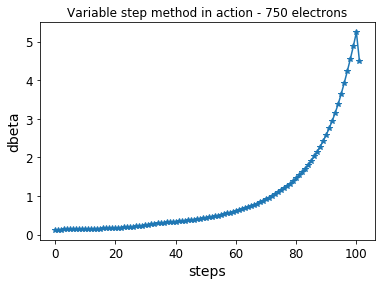

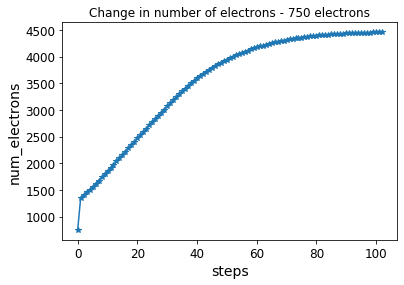

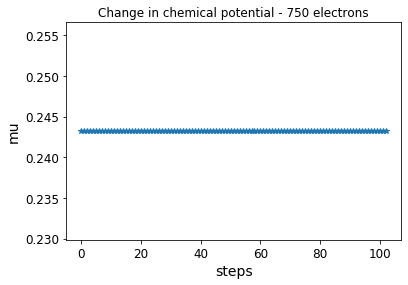

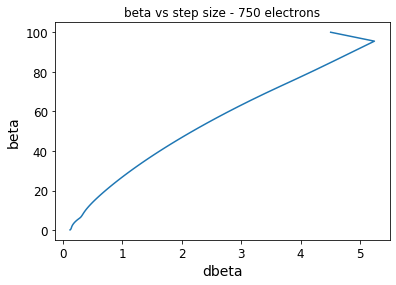

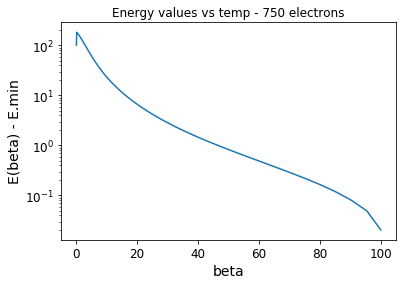

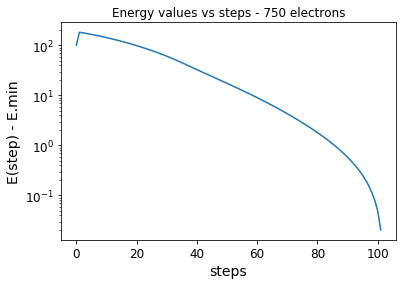

In [49]:
plot_results_fd_vs_c(num_electrons, ferm_exact_250, sqrt_c_250)

101
Best score and index:  (0.9997064426322505, 90)
Cv @ 298.15 K =  [[-0.70233102]]
Slope =  [[0.00146286]]


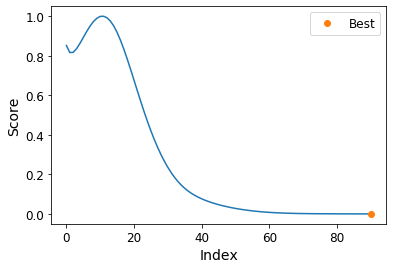

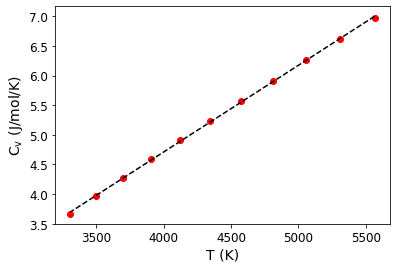

In [50]:
beta_vals_250 = np.cumsum(sqrt_c_250.beta_increments)
T_250 = 1 / (beta_vals_250 * k) # K

# c.cv is in units of 1/atom multiplying by k gives Eh/atom/K
# To get J/mol/K we need to multiply by 4.3597447222×10^-18 J/Eh * Na atoms/mol
# This = 2.63e6
cv_250 = np.array(sqrt_c_250.cv)[:-1] * k * 2.63e6 / 250
print(cv_250.size)
best_linear_reg(T_250[:-1], cv_250, 10)

In [51]:
isq = funm_herm(S_250, lambda x: -1/np.sqrt(x))
Ho_250 = isq @ H_250 @ isq
 
w, v = linalg.eigh(Ho_250)
we = [1.0/(1 + np.exp(beta*(x - mu_250))) for x in w]
P = v.dot(np.diag(we)).dot(v.T)
print("Energy = ", np.trace(Ho_250 @ P))

print("Energy nonorth = ", np.trace(sqrt_c_250.A @ sqrt_c_250.rho))

Energy =  -96.6196512171261
Energy nonorth =  (-232.28314958387634+0j)


Text(0.5, 0, 'Num atoms')

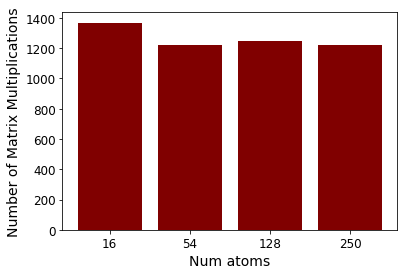

In [53]:
x = [1, 2, 3, 4]
multiplier = 6
y = [multiplier*sqrt_c_16.count,
     multiplier*sqrt_c_54.count,
     multiplier*sqrt_c_128.count,
     multiplier*sqrt_c_250.count]
ax = plt.subplot()
ax.bar(x, y, color='maroon')
ax.set_ylabel("Number of Matrix Multiplications")
ax.set_xticklabels(['16', '54', '128', '250'])
ax.set_xticks(x)
ax.set_xlabel("Num atoms")

In [ ]:
sqrt_c_test = CAdaptive_C_RK4_sqrt(ovlp=S_250, H=H_250, num_electrons=num_electrons,
                                  dbeta=dbeta, epsilon=1e-2, tol=1e-6)
sqrt_c_test.propagate(200, sqrt_c_test.single_step_rk2)

In [ ]:
beta_vals_test = np.cumsum(sqrt_c_test.beta_increments)
T_test = 1 / (beta_vals_test * k) # K

# c.cv is in units of 1/atom multiplying by k gives Eh/atom/K
# To get J/mol/K we need to multiply by 4.3597447222×10^-18 J/Eh * Na atoms/mol
# This = 2.63e6
cv_test = np.array(sqrt_c_test.cv)[:-1] * k * 2.63e6 / 250
print(cv_test.size)
best_linear_reg(T_test[:-1], cv_test, )